In [1]:
#  -------------------------------------------------------------------------------------------
#  Copyright (c) Microsoft Corporation. All rights reserved.
#  Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.
#  -------------------------------------------------------------------------------------------

# Phrase grounding

This notebook demonstrates the usage of the BioViL image and text models in a multi-modal phrase grounding setting.
Given a chest X-ray and a radiology text phrase, the joint model grounds the phrase in the image, i.e., highlights the regions of the image that share features similar to the phrase.

Please refer to the ECCV'22 manuscript for further details:

> Boecking, B., Usuyama, N. et al. (2022). Making the Most of Text Semantics to Improve Biomedical Vision–Language Processing. In: Avidan, S., Brostow, G., Cissé, M., Farinella, G.M., Hassner, T. (eds) Computer Vision – ECCV 2022. ECCV 2022. Lecture Notes in Computer Science, vol 13696. Springer, Cham. [https://doi.org/10.1007/978-3-031-20059-5_1](https://doi.org/10.1007/978-3-031-20059-5_1)

The notebook can also be run on Binder without the need of any coding or local installation:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/microsoft/hi-ml/HEAD?labpath=hi-ml-multimodal%2Fnotebooks%2Fphrase_grounding.ipynb)

This demo is solely for research evaluation purposes, not intended to be a medical product or clinical use.

## Setup

Let's first install the `hi-ml-multimodal` Python package, which will allow us to import the `health_multimodal` Python module.

In [2]:
pip_source = "hi-ml-multimodal"

In [3]:
%pip install {pip_source}

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
sys.path.insert(0,'/home/ozoktay/workspace/hi-ml/hi-ml-multimodal/src')

In [5]:
from typing import List, Tuple

import tempfile
from pathlib import Path

import torch

from health_multimodal.text import get_bert_inference
from health_multimodal.image import get_image_inference
from health_multimodal.vlp import ImageTextInferenceEngine
from health_multimodal.common.visualization import plot_phrase_grounding_similarity_map

## Load multimodal model

Load the text and image models from [Hugging Face 🤗](https://aka.ms/biovil-models) and instantiate the inference engines:

In [6]:
text_inference = get_bert_inference("biovil_t_bert")
image_inference = get_image_inference("biovil_t")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.


Using downloaded and verified file: /tmp/biovil_t_image_model_proj_size_128.pt


/home/ozoktay/.conda/envs/himl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-eoxszjt0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Instantiate the joint inference engine:

In [7]:
image_text_inference = ImageTextInferenceEngine(
    image_inference_engine=image_inference,
    text_inference_engine=text_inference,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_text_inference.to(device)

## Helper visualization functions

In [8]:
def plot_phrase_grounding(image_path: Path, text_prompt: str, bboxes: List[Tuple[float, float, float, float]]) -> None:
    similarity_map = image_text_inference.get_similarity_map_from_raw_data(
        image_path=image_path,
        query_text=text_prompt,
        interpolation="bilinear",
    )
    plot_phrase_grounding_similarity_map(
        image_path=image_path,
        similarity_map=similarity_map,
        bboxes=bboxes
    )

def plot_phrase_grounding_from_url(image_url: str, text_prompt: str, bboxes: List[Tuple[float, float, float, float]]) -> None:
    image_path = Path(tempfile.tempdir, "downloaded_chest_xray.jpg")
    !curl -s -L -o {image_path} {image_url}
    plot_phrase_grounding(image_path, text_prompt, bboxes)

## Inference

We will run inference on a chest X-ray from [Open-i](https://openi.nlm.nih.gov/detailedresult?img=CXR111_IM-0076-1001&req=4), but any other chest X-ray image in DICOM or JPEG format can be used for research purposes.

Phrase grounding results
 -- Ground-truth bounding box annotations for the phrase 'Left basilar consolidation seen.' is shown in black

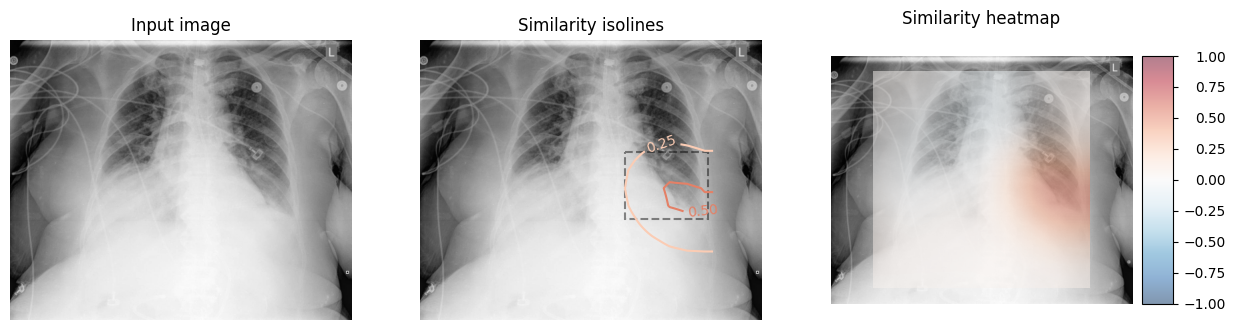

In [14]:
image_url = "https://openi.nlm.nih.gov/imgs/512/242/1445/CXR1445_IM-0287-4004.png"
text_prompt = "Left basilar consolidation seen."

# Ground-truth bounding box annotations for the phrase "Left basilar consolidation seen."
bboxes = [[306, 168, 124, 101]]

# Import ipython display and show the following text "hello world"
from IPython.display import display, Markdown
display(Markdown("Phrase grounding results -- Ground-truth bounding box annotations for the phrase 'Left basilar consolidation seen.' is shown in black"))

plot_phrase_grounding_from_url(image_url, text_prompt, bboxes)